<a href="https://colab.research.google.com/github/yanada1307/14IF_Multi-label-Emotion-Classification/blob/main/Proyek_PBA_Sprinkle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **PROYEK PBA KELOMPOK SPRINKLE**
**Pemrosesan Bahasa Alami**

**Selasa, 23 November 2021**


1.   11S18015 - Yanada Sari Br Situmorang
2.   11S18002 - Putri Era Waty Bakara
3.   11S18010 - N. Priskila Napitupulu
4.   11S18012 - Suryani Vebhitry Siahaan
5.   11S18038 - Grace Winda N Naibaho
6.   11S18063 - Elyta Junetta Siregar





---

In [33]:
!pip3 install datasets transformers -q

In [34]:
!pip install tez

In [35]:
from datasets import load_dataset

import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from torch.utils.data import DataLoader

import os
import random
import tez
import torch
import torch.nn as nn
import transformers
from sklearn import metrics, model_selection, preprocessing
from transformers import AdamW, get_linear_schedule_with_warmup

**Load dataset go_emotions dan split menjadi train, validation, dan test**

In [36]:
go_emotions = load_dataset("go_emotions")

data = go_emotions.data

No config specified, defaulting to: go_emotions/simplified
Reusing dataset go_emotions (/root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)


  0%|          | 0/3 [00:00<?, ?it/s]

In [37]:
train = go_emotions.data["train"].to_pandas()
valid = go_emotions.data["validation"].to_pandas()
test = go_emotions.data["test"].to_pandas()

In [38]:
print(train.shape, valid.shape, test.shape)

(43410, 3) (5426, 3) (5427, 3)


In [39]:
train.head() 

,text,labels,id
0,My favourite food is anything I didn't have to...,[27],eebbqej
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj
3,To make her feel threatened,[14],ed7ypvh
4,Dirty Southern Wankers,[3],ed0bdzj


**Convert dataset menjadi representasi one-hot**

In [40]:
mapping = {
    0:"admiration",
    1:"amusement",
    2:"anger",
    3:"annoyance",
    4:"approval",
    5:"caring",
    6:"confusion",
    7:"curiosity",
    8:"desire",
    9:"disappointment",
    10:"disapproval",
    11:"disgust",
    12:"embarrassment",
    13:"excitement",
    14:"fear",
    15:"gratitude",
    16:"grief",
    17:"joy",
    18:"love",
    19:"nervousness",
    20:"optimism",
    21:"pride",
    22:"realization",
    23:"relief",
    24:"remorse",
    25:"sadness",
    26:"surprise",
    27:"neutral",
}

n_labels = len(mapping)

In [41]:
def one_hot_labels(df):
    dict_labels= []
    for i in tqdm(range(len(df))):
        d = [0]*n_labels
        labels = df.iloc[i]["labels"]
        
        for label in labels:
            d[label] = 1
        dict_labels.append(d)
        
    return pd.DataFrame(dict_labels)

In [42]:
train_oh_labels = one_hot_labels(train)
valid_oh_labels = one_hot_labels(valid)
test_oh_labels = one_hot_labels(test)

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

In [43]:
train_oh_labels.shape

(43410, 28)

In [44]:
train = pd.concat([train, train_oh_labels], axis=1)
valid = pd.concat([valid, valid_oh_labels], axis=1)
test = pd.concat([test, test_oh_labels], axis=1)

**Cek kembali datanya**

In [45]:
print(train.shape, valid.shape, test.shape)

(43410, 31) (5426, 31) (5427, 31)


In [46]:
train.head()

,text,labels,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,My favourite food is anything I didn't have to...,[27],eebbqej,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,To make her feel threatened,[14],ed7ypvh,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Dirty Southern Wankers,[3],ed0bdzj,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


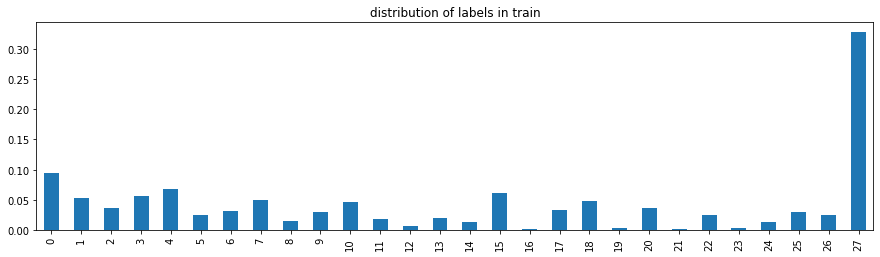

In [47]:
fig = plt.figure(figsize=(15, 13))

ax1 = plt.subplot(3, 1, 1)
train[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax1, title="distribution of labels in train")

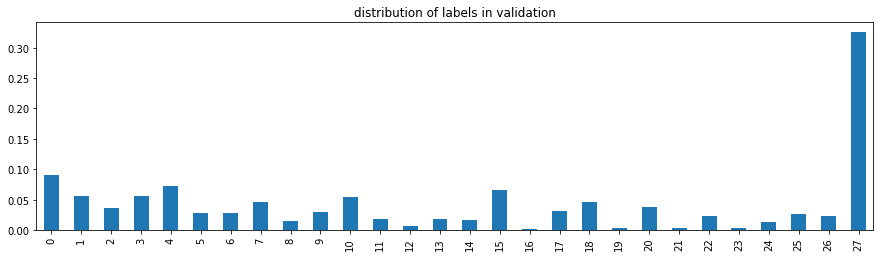

In [48]:
fig = plt.figure(figsize=(15, 13))

ax2 = plt.subplot(3, 1, 2)
valid[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax2, title="distribution of labels in validation")

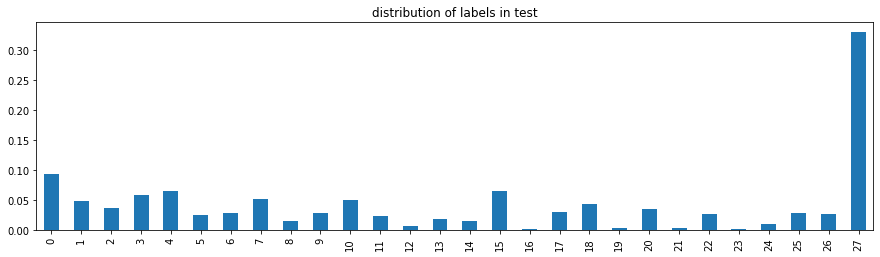

In [49]:
fig = plt.figure(figsize=(15, 13))

ax3 = plt.subplot(3, 1, 3)
test[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax3, title="distribution of labels in test")

In [50]:
def inspect_data(label, n=5):
    samples = train[train[label] == 1].sample(5)
    sentiment = mapping[label]
    
    print(f"examples from {sentiment}")
    print()
    for text in samples["text"]:
        print(text)
        print("---")

**Beberapa ulasan dari emotions**

In [51]:
inspect_data(0)

examples from admiration

Good [NAME] ^(that's perfect)
---
Appreciate you keeping to the bet. The other guy hasn't yet. Take care bro.
---
Ya. It's not what you think to start. Awesome show ending within 5 seasons with a planned ending. It's refreshingly hilarious. Netflix available.
---
Hey, I get your point of view. I appreciate the explanation. :)
---
That's cute. Sincerely Nepal, 7.6
---


In [52]:
inspect_data(1)

examples from amusement

Omg just drink some water then bro lol
---
Weird game lol
---
RIP manning lol
---
This was the most fun I've had watching a game since [NAME] 35 point game
---
> a mother in law unit Apropos of this and not the main thing.. lol! We call them granny flats in Aus :)
---


In [53]:
inspect_data(2)

examples from anger

Unemployment was also significantly higher at the end of Old Labours tenure than at the beginning. Yet nobody remembers that.
---
[NAME] damn cummonists
---
Every point you make is proven wrong lol. Just stop.
---
“Don’t discipline my kid!”
---
Yes! What the hell is it with ikea? My husband and I don’t go together anymore.
---


In [54]:
inspect_data(3)

examples from annoyance

we are at !CURSED! levels of cursed
---
too much logic in there for remainiacs only interested in cheering for unicorns and insulting the british people.
---
Vamos [NAME], keep fighting! 
---
Society has once again falsely made men look cold and emotionless. You're normal.
---
That’s because it’s stupid and nobody wants it!
---


In [55]:
inspect_data(4)

examples from approval

Exactly. Stop talking and let the adults speak u/MeatheadVernacular.
---
If we hurry, we can still catch the heroin craze! 
---
You’re right. My biggest pet peeve is the lights, it washes out all the colors and textures, I hate that BGs use them
---
That was the best time to be Black in LA
---
Have to admit, a completed quest log would've been nice.
---


In [56]:
inspect_data(5)

examples from caring

From red deer as well. Don't worry not all of us are ignorant and hateful.
---
This will pass and you will be happy again. Just not right now. Hang in there.
---
Yeah, you're getting points. Bring your insurance documents as well just to save yourself the trip back. They will ask for them.
---
As far as I'm concerned, [NAME] run for the WH ended with this twisted ankle.
---
If you drop your toy gun and someone picks it up and points it at you, you're not going to be threatened by it.
---


**Menetukan kumpulan data PyTorch**

In [57]:
class GoEmotionDataset():
    def __init__(self, texts, targets):
        self.texts = texts
        self.targets = targets
        self.tokenizer = transformers.SqueezeBertTokenizer.from_pretrained(
            "squeezebert/squeezebert-uncased", do_lower_case=True
        )
        self.max_len = 35
 
    def __len__(self):
        return len(self.texts)

    
    def __getitem__(self, index):
        target = self.targets[index]
        text = self.texts[index]

        inputs = self.tokenizer.encode_plus(text,
                                            None,
                                            add_special_tokens=True,
                                            max_length=self.max_len,
                                            padding="max_length",
                                            truncation=True)
        
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "targets": torch.tensor(self.targets[index], dtype=torch.long),
        }

**Mendefinisikan Tez** 

In [58]:
class EmotionClassifier(tez.Model):
    def __init__(self, num_train_steps, num_classes):
        super().__init__()
        self.bert = transformers.SqueezeBertModel.from_pretrained("squeezebert/squeezebert-uncased")
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(768, num_classes)
        self.num_train_steps = num_train_steps
        self.step_scheduler_after = "batch"

In [59]:
    def fetch_optimizer(self):
        param_optimizer = list(self.named_parameters())
        no_decay = ["bias", "LayerNorm.bias"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        opt = AdamW(optimizer_parameters, lr=3e-5)
        return opt

In [60]:
    def fetch_scheduler(self):
        sch = get_linear_schedule_with_warmup(
            self.optimizer, num_warmup_steps=0, num_training_steps=self.num_train_steps
        )
        return sch
    
    def loss(self, outputs, targets):
        if targets is None:
            return None
        return nn.BCEWithLogitsLoss()(outputs, targets.float())

In [61]:
def monitor_metrics(self, outputs, targets):
        if targets is None:
            return {}
        
        outputs = torch.sigmoid(outputs)
        outputs = outputs.cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()
        
        fpr_micro, tpr_micro, _ = metrics.roc_curve(targets.ravel(), outputs.ravel())
        auc_micro = metrics.auc(fpr_micro, tpr_micro)
        return {"auc": auc_micro}

In [62]:
def forward(self, ids, mask, targets=None):
        o_2 = self.bert(ids, attention_mask=mask)["pooler_output"]
        b_o = self.bert_drop(o_2)
        output = self.out(b_o)
        loss = self.loss(output, targets)
        acc = self.monitor_metrics(output, targets)
        return output, loss, acc

**Melai Pelatihan**

In [63]:
train_dataset = GoEmotionDataset(train.text.tolist(), train[range(n_labels)].values.tolist())
valid_dataset = GoEmotionDataset(valid.text.tolist(), valid[range(n_labels)].values.tolist())

In [ ]:
n_train_steps = int(len(train) / 32 * 10)
model = EmotionClassifier(n_train_steps, n_labels)

tb_logger = tez.callbacks.TensorBoardLogger(log_dir="logs/")
es = tez.callbacks.EarlyStopping(monitor="valid_loss", model_path="export/model.bin")

In [ ]:
model.fit(train_dataset,
          valid_dataset, 
          train_bs=64,
          device="cuda", 
          epochs=8, 
          callbacks=[tb_logger, es], 
          fp16=Trues, 
          n_jobs=12)

In [ ]:
# train model
model.fit(
    train_dataset,
    valid_dataset=valid_dataset,
    train_bs=32,
    device="cuda",
    epochs=4,
    callbacks=[tb_logger, es],
    fp16=True
)

# save model
model.save("model.bin")